In [658]:
from shapely import voronoi_polygons, MultiPoint, box, affinity
from shapely.ops import voronoi_diagram
import matplotlib.pyplot as plt
import numpy as np
import colorsys
import json
import csv

In [659]:
from dimensionality_reduction import reduce_dimensions

In [660]:
from tree import build_tree, get_all_centroids

In [661]:
EMBEDDINGS_FILE = 'embeddings.json'
REDUCED_FILE = 'reduced_embeddings_2d.csv'

In [662]:
with open(EMBEDDINGS_FILE,'r') as infile:
    data = json.load(infile)

In [663]:
embedding_labels = list(data.keys())
labels = [l[:-3] for l in embedding_labels] # get rid of '.md' file extension

In [664]:
embeddings = np.array([data[label] for label in embedding_labels])
latent_space = reduce_dimensions(embeddings,2)

In [665]:
with open(REDUCED_FILE, 'w') as outfile:
    writer = csv.writer(outfile)
    writer.writerow(['x','y','filename'])
    for label, coords in zip(labels, latent_space):
        writer.writerow([coords[0],coords[1],label])

In [666]:
tree = build_tree(EMBEDDINGS_FILE)

In [667]:
tree.get_children()

594

In [668]:
points = MultiPoint(latent_space)

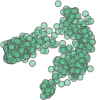

In [669]:
points

In [670]:
bounding_box = box(*points.bounds)
bounding_box = affinity.scale(bounding_box, xfact=1.2, yfact=1.2)

In [671]:
bounding_box.exterior.xy

(array('d', [0.3332092335684297, 0.3332092335684297, -0.319747125771029, -0.319747125771029, 0.3332092335684297]),
 array('d', [-0.33075990992566723, 0.35169511327884145, 0.35169511327884145, -0.33075990992566723, -0.33075990992566723]))

In [672]:
polygons = voronoi_polygons(points)

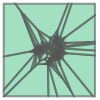

In [673]:
polygons

In [674]:
color_space = reduce_dimensions(embeddings,3)
color_space = (color_space-np.min(color_space))/(np.max(color_space)-np.min(color_space))

In [675]:
hsv_colors = [colorsys.rgb_to_hsv(*color) for color in color_space]
tweaked_colors = [colorsys.hsv_to_rgb(hue, saturation/2, 1-((1-value)/1.25)) for hue,saturation,value in hsv_colors]

In [676]:
# 1D color space, hue-only, saturation and value are constants
color_space_1d = reduce_dimensions(embeddings,1)
color_space_1d = (color_space_1d-np.min(color_space_1d))/(np.max(color_space_1d)-np.min(color_space_1d))
color_space_1d = [colorsys.hsv_to_rgb(hue[0]/1.3, 0.25, 0.85) for hue in color_space_1d]

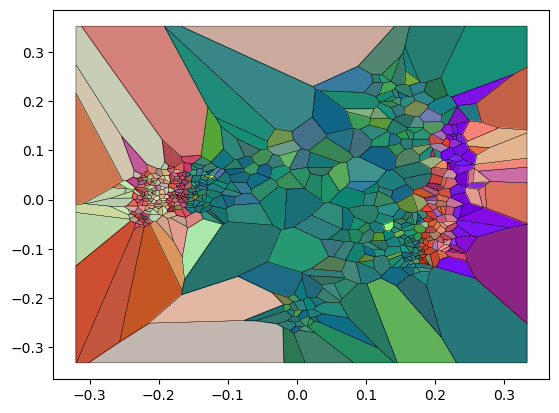

In [677]:
for i, polygon in enumerate(polygons.geoms):
    clipped_polygon = polygon.intersection(bounding_box)
    plt.plot(*clipped_polygon.exterior.xy, c='black', linewidth=0.2)
    plt.fill(*clipped_polygon.exterior.xy, c=color_space[i])
plt.show()

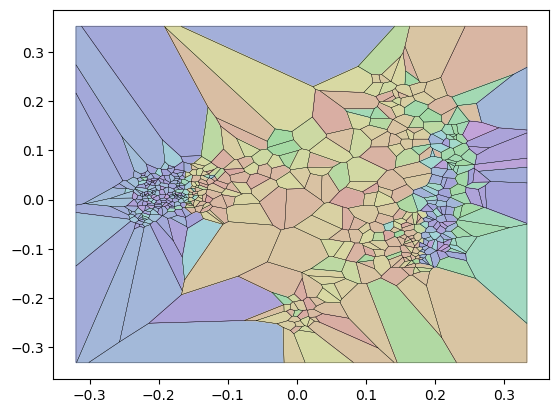

In [678]:
for i, polygon in enumerate(polygons.geoms):
    clipped_polygon = polygon.intersection(bounding_box)
    plt.plot(*clipped_polygon.exterior.xy, c='black', linewidth=0.2)
    plt.fill(*clipped_polygon.exterior.xy, c=color_space_1d[i])
plt.show()